## BPM algorithm comparison

We are comparing different BPM detection algorithms to see how they function on different collections of music.

Some resources as starting points:

Music Tempo Estimation: Are We Done Yet? https://transactions.ismir.net/articles/10.5334/tismir.43/
 * Associated website https://tempoeval.github.io/tempo_eval/

ISMIR 2021 tutorial on Tempo, Beat, and Downbeat Estimation https://tempobeatdownbeat.github.io/tutorial/intro.html

Mirex evaluation campaign: https://www.music-ir.org/mirex/wiki/2021:Audio_Tempo_Estimation


### Evaluation
Lots of good questions in https://transactions.ismir.net/articles/10.5334/tismir.43/ about
 * Which metrics are useful to evaluate with
 * How to build a dataset
 * How to determine if a dataset is representative
 * How to evaluate algorithms that are targetted to one style on datasets of another style of music

### Further questions
Global vs Local estimation?

Moelants, D. and McKinney, M.F. (2004), Tempo perception and musical content: What makes a piece slow, fast, or temporally ambiguous? International Conference on Music Perception & Cognition, Evanston, IL. URL: http://icmpc8.umn.edu/proceedings/ICMPC8/PDF/AUTHOR/MP040237.PDF

Should we do an evaluation of _tempogram_? (change in the tempo throughout a song)


## Algorithms

According to _Are we Done Yet?_, Bock 2015 and Schreiber 2018b achive "near-perfect" results:
* Bock, S., Krebs, F., & Widmer, G. (2015). Accurate tempo estimation based on recurrent neural networks and resonating comb filters. ISMIR 2015. 
* Schreiber, H., & Muller, M. (2018b). A single-step approach to musical tempo estimation using a convolutional neural network. ISMIR 2018.

https://www.music-ir.org/mirex/wiki/2018:MIREX2018_Results

### TempoCNN
Hendrik Schreiber PhD thesis: Data-Driven Approaches for Tempo and Key Estimation of Music Recordings (https://d-nb.info/1214888569/34)

https://github.com/hendriks73/tempo-cnn (AGPL-3)

Requires tensorflow 1.15, which is only available for Python 3.7 and earlier


### Essentia
https://essentia.upf.edu/tutorial_rhythm_beatdetection.html
* BeatTrackerMultiFeature (accurate+slow)
* BeatTrackerDegara (OK+faster)
* PercivalBpmEstimator

### Vamp
https://vamp-plugins.org/plugin-doc/qm-vamp-plugins.html#qm-tempotracker

Download from https://code.soundsoftware.ac.uk/projects/qm-vamp-plugins/files for your architecture

Python package to process vamp plugins: https://pypi.org/project/vamp/

### Madmom
https://github.com/CPJKU/madmom (Code BSD, Data CC by-nc-sa)

Implementation of Bock 2015, but also updated recently and used in the 2021 tutorial (which is based on 2020 paper)

http://ismir2015.uma.es/articles/196_Paper.pdf


TempoDetector and TCNTempoDetector

In [1]:
import os
os.environ['VAMP_PATH'] = os.path.join(os.getcwd(), "qm-vamp-plugins-1.8.0-linux64")

import math
import statistics
import time

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = {}

In [2]:
!ls music/'Queen - 1981 - Greatest Hits'

'01 - Queen - Bohemian Rhapsody.mp3'
'02 - Queen - Another One Bites the Dust.mp3'
'03 - Queen - Killer Queen.mp3'
'04 - Queen - Fat Bottomed Girls.mp3'
'05 - Queen - Bicycle Race.mp3'
'06 - Queen - You’re My Best Friend.mp3'
'07 - Queen - Don’t Stop Me Now.mp3'
'08 - Queen - Save Me.mp3'
'09 - Queen - Crazy Little Thing Called Love.mp3'
'10 - Queen - Somebody to Love.mp3'
'11 - Queen - Now I’m Here.mp3'
'12 - Queen - Good Old‐Fashioned Lover Boy.mp3'
'13 - Queen - Play the Game.mp3'
'14 - Queen - Flash.mp3'
'15 - Queen - Seven Seas of Rhye.mp3'
'16 - Queen - We Will Rock You.mp3'
'17 - Queen - We Are the Champions.mp3'
 cover.jpg


In [3]:
f = "music/Queen - 1981 - Greatest Hits/04 - Queen - Fat Bottomed Girls.mp3"

Queen Mary tempo tracker, distributed as a vamp plugin

The output of this is a list of timestamps/bpms throughout the length of the input track

    {'list': [{'timestamp':  0.417959183, 'label': '87.59 bpm'}, {'timestamp......] }
    
so we take all of the BPMs and take their mean. See some other points in _Are we Done Yet?_ which suggests that median may be a better option to better treat tracks where the tempo changes significantly at some point.

In [4]:
import vamp
import librosa



data, rate = librosa.load(f)
start = time.monotonic()
beats = vamp.collect(data, rate, "qm-vamp-plugins:qm-tempotracker")
end = time.monotonic()
vamp_beats = [float(b["label"].replace(" bpm", "")) for b in beats["list"] if b["label"]]
vamp_bpm = round(statistics.mean(vamp_beats), 2)
results["vamp    "] = {"bpm": vamp_bpm, "time": round(end-start, 2)}

/home/alastair/code/metabrainz/music-analysis/env/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


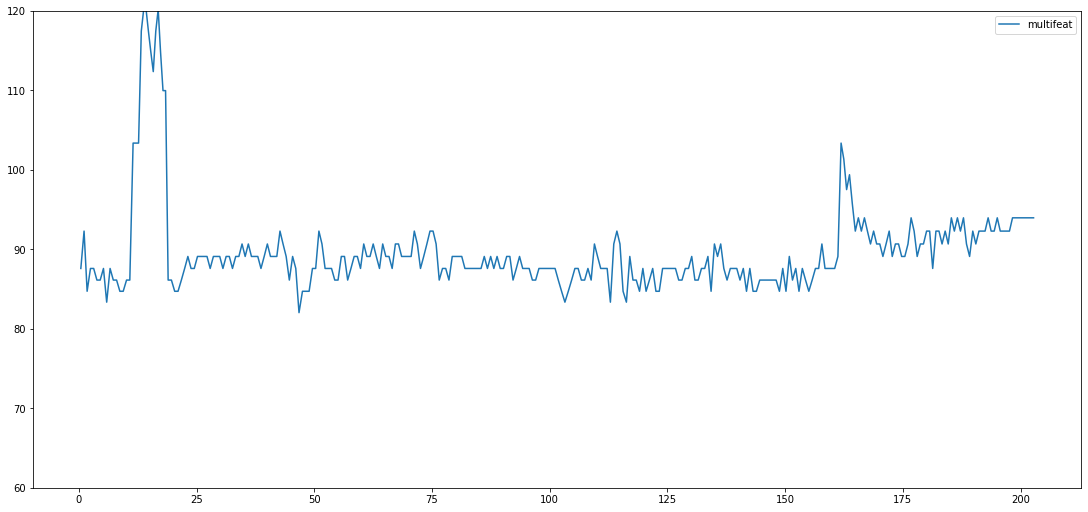

In [5]:
newbeats = [(float(b['timestamp']), float(b["label"].replace(" bpm", ""))) for b in beats["list"] if b["label"]]
x = [i[0] for i in newbeats]
y = [i[1] for i in newbeats]

fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
ax.plot(x, y, label='multifeat')

ax.set_ylim([60, 120])

ax.legend()

Three BPM extractors from Essentia - these are independent implementations of previously published algorithms

In [6]:
import essentia.standard as es

# Loading an audio file.
audio = es.MonoLoader(filename="music/Queen - 1981 - Greatest Hits/04 - Queen - Fat Bottomed Girls.mp3")()

# Slow
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
start = time.monotonic()
bpm, beats, beats_confidence, multifeat_bpms, beats_intervals = rhythm_extractor(audio)
end = time.monotonic()

print(f"multifeature BPM: {bpm}")
print(f"Beat estimation confidence: {beats_confidence}")
print(f"time: {round(end-start, 2)}")
results["ess-multifeat"] = {"bpm": bpm, "confidence": beats_confidence, "time": round(end-start, 2)}

# faster
rhythm_extractor = es.RhythmExtractor2013(method="degara")
start = time.monotonic()
bpm, beats, beats_confidence, degara_bpms, beats_intervals = rhythm_extractor(audio)
end = time.monotonic()
print(f"degara BPM: {bpm}")
print(f"Beat estimation confidence: {beats_confidence}")
print(f"time: {round(end-start, 2)}")
results["ess-degara"] = {"bpm": bpm, "confidence": beats_confidence, "time": round(end-start, 2)}

# PercivalBpmEstimator
start = time.monotonic()
bpm = es.PercivalBpmEstimator()(audio)
end = time.monotonic()

print(f"Percival BPM: {bpm}")
print(f"Beat estimation confidence: {beats_confidence}")
print(f"time: {round(end-start, 2)}")
results["ess-percival"] = {"bpm": bpm, "confidence": beats_confidence, "time": round(end-start, 2)}

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default
[ WARNING  ] AudioLoader: invalid frame, skipping it: Invalid data found when processing input


multifeature BPM: 88.5963363647461
Beat estimation confidence: 2.027797222137451
time: 2.02
degara BPM: 88.57476806640625
Beat estimation confidence: 0.0
time: 0.47
Percival BPM: 89.10291290283203
Beat estimation confidence: 0.0
time: 0.61


[   INFO   ] On connection Flux::flux → IIR::signal:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


In [7]:
# based on the file loaded with librosa
duration= math.floor(len(data) / rate)
mf_x = np.linspace(0, duration, len(multifeat_bpms))
dg_x = np.linspace(0, duration, len(degara_bpms))

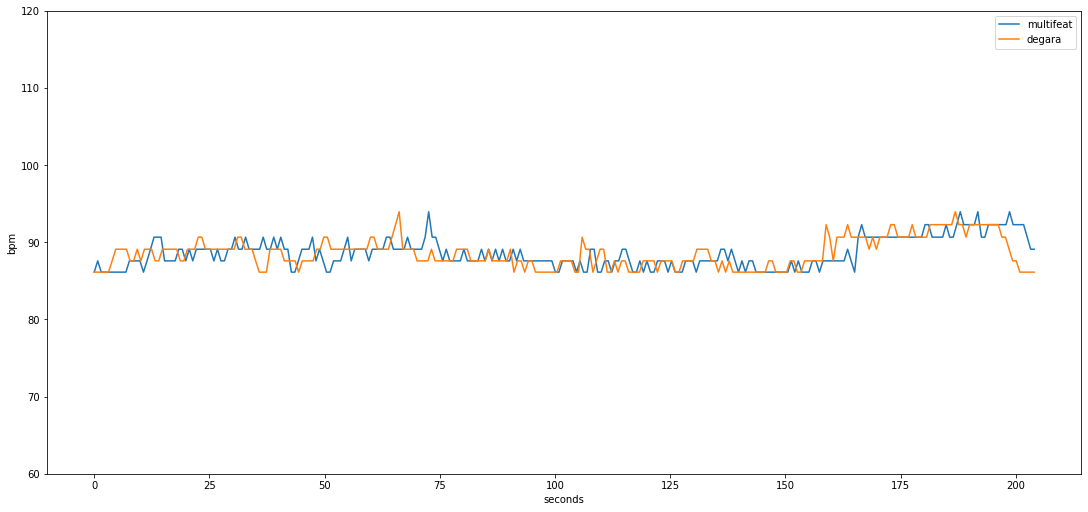

In [8]:
fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
ax.plot(mf_x, multifeat_bpms, label='multifeat')
ax.plot(dg_x, degara_bpms, label='degara')
ax.set_xlabel('seconds')  # Add an x-label to the axes.
ax.set_ylabel('bpm')  # Add a y-label to the axes.

ax.set_ylim([60, 120])

ax.legend()

TempoCNN
Comes with 8 different models: [ismir2018|fma2018|cnn|fcn|mazurka|deeptemp|deepsquare|shallowtemp], but at the moment we're just using fcn, the default

2022-01-21 17:45:57.202931: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-01-21 17:45:57.225388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3693010000 Hz
2022-01-21 17:45:57.226171: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561420d4f3f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-21 17:45:57.226188: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Loaded model with 313136 parameters.


/home/alastair/code/metabrainz/music-analysis/env/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TempoCNN BPM: 87
time: 5.06 (includes file load)


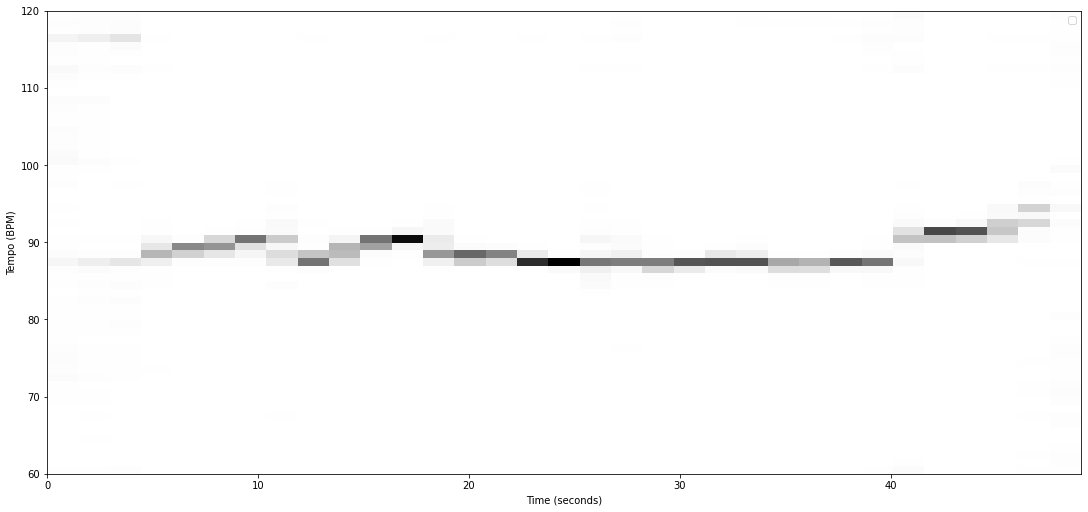

In [9]:
from tempocnn.classifier import TempoClassifier, MeterClassifier
from tempocnn.feature import read_features


#  [ismir2018|fma2018|cnn|fcn|mazurka|deeptemp|deepsquare|shallowtemp],
model = 'fcn' # default
classifier = TempoClassifier(model)
print('Loaded model with {} parameters.'.format(classifier.model.count_params()))

start = time.monotonic()
features = read_features("music/Queen - 1981 - Greatest Hits/04 - Queen - Fat Bottomed Girls.mp3")
tempo = classifier.estimate_tempo(features, interpolate=False)
end = time.monotonic()
print(f"TempoCNN BPM: {tempo}")
print(f"time: {round(end-start, 2)} (includes file load)")
results["tempocnn"] = {"bpm": tempo, "time": str(round(end-start, 2)) + " (includes file load)"}


predictions = classifier.estimate(features)

"""
# from https://github.com/hendriks73/tempo-cnn/blob/main/tempocnn/commands.py#L329
        norm_frame = args.norm_frame
        if norm_frame is not None:
            predictions = _norm_tempogram_frames(predictions, norm_frame)

        sharpen = args.sharpen
        if sharpen:
            predictions = (predictions.T / np.max(predictions, axis=1)).T
            predictions = np.where(predictions != 1, 0, predictions)
"""

# default
hop_length = 32
sr = 11025.0
fft_hop_length = 512.0

max_windows = predictions.shape[0] * hop_length
max_length_in_s = max_windows * (fft_hop_length / sr)
frame_length = (fft_hop_length / sr) * hop_length

# defaults
min_bpm, max_bpm, max_ylim = [30, 286, 300]

fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
ax.set_ylim([60, 120])
ax.imshow(predictions.T, origin='lower', cmap='Greys', aspect='auto',
          extent=(0, max_length_in_s, min_bpm, max_bpm))
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Tempo (BPM)')

ax.legend()

Madmom

In [10]:
from madmom.audio import SignalProcessor
from madmom.features import (ActivationsProcessor, BeatDetectionProcessor,
                             RNNBeatProcessor, TempoEstimationProcessor)
from madmom.features.beats import TCNBeatProcessor
from madmom.io import write_beats
from madmom.processors import IOProcessor, io_arguments
import madmom


f = "music/Queen - 1981 - Greatest Hits/04 - Queen - Fat Bottomed Girls.mp3"
proc = RNNBeatProcessor()
# TCNBeatProcessor doesn't work out of the box: https://github.com/CPJKU/madmom/issues/500
# proc = TCNBeatProcessor(tasks=(1,))

tempo = TempoEstimationProcessor(method='comb', min_bpm=40., fps=100,
                                           max_bpm=250., act_smooth=0.14,
                                           hist_smooth=9, hist_buffer=10.,
                                           alpha=0.79, visualize=False)
tempo.visualize = False
start = time.monotonic()
beats = proc(f)
t = tempo.process_online(beats)
end = time.monotonic()
print(f"Madmom: {round(t.tolist()[0][0], 2)}")
print(f"time: {round(end-start, 2)} (includes file load)")
results["madmom   "] = {"bpm": round(t.tolist()[0][0], 2), "time": str(round(end-start, 2)) + " (includes file load)"}

/home/alastair/code/metabrainz/music-analysis/env/lib/python3.7/site-packages/madmom/features/tempo.py:725: UserWarning: Usage of `method` is deprecated as of version 0.17. Please pass a dedicated `TempoHistogramProcessor` instance as `histogram_processor`.Functionality will be removed in version 0.19.
  'Usage of `method` is deprecated as of version 0.17. '


Madmom: 88.24
time: 20.94 (includes file load)


In [11]:
t

array([[8.82352941e+01, 2.50015588e-01],
       [4.37956204e+01, 1.58124777e-01],
       [1.76470588e+02, 1.14445974e-01],
       [6.89655172e+01, 8.21710163e-02],
       [5.82524272e+01, 7.84093968e-02],
       [1.33333333e+02, 6.40142485e-02],
       [5.26315789e+01, 6.15768246e-02],
       [1.17647059e+02, 5.50846355e-02],
       [4.95867769e+01, 5.30524848e-02],
       [4.08163265e+01, 4.34277037e-02],
       [2.22222222e+02, 3.96773513e-02]])

Some results

In [12]:
print(f)
print("algorithm\tbpm\ttime (sec)")
for alg, data in results.items():
    print(alg + "\t" + str(round(data["bpm"], 2)) + "\t" + str(data["time"]))


music/Queen - 1981 - Greatest Hits/04 - Queen - Fat Bottomed Girls.mp3
algorithm	bpm	time (sec)
vamp    	89.9	0.44
ess-multifeat	88.6	2.02
ess-degara	88.57	0.47
ess-percival	89.1	0.61
tempocnn	87	5.06 (includes file load)
madmom   	88.24	20.94 (includes file load)
